# Clustering

<img src="https://www.mrtfuelcell.polimi.it/images/logo_poli.jpg" height="200">

**Basi Fondamentali del Machine Learning**

Day 6 - 2024-11-4

Michael Wood, Maciej Sakwa, Emanuele Ogliari


![clustering algorithm](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/clustering_algorithm_8d26475260.png?raw=true)

## Outline

1. Machine Learning Project Structure (review)
2. Bad Data: detection and replacement (intro)
3. Z-score
4. K-means clustering

## Learning obejctives

* Understand the differences between classification and clustering problems
* Use a simple clustering method for outlier detection (z-score)
* Follow the k-means clustering algorithm and apply it to outlier detection



---

# Packages etc 

**Please run the cells below** 

Packages:

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import seaborn as sns
from math import nan
import matplotlib.dates as mdates

Options:

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.plotting.backend='plotly'

Import data:

In [3]:
def import_data(filepath):
    df = pd.read_csv(filepath,comment='#',index_col=0,parse_dates=True)
    df = df.rename(columns={'Load (kW)':'Load'})
    df = df.resample('1h').mean() # just to establish freq
    #df['persist7D'] = df['Load'].shift(7*96)
    df = df['2018-10-15':'2020-2-28'] # cut out startup period and covid
    df = df/10
    #df = df[df.index.weekday<4]
    return df.round(1)

Plots:

In [4]:
def plot_superimpose(ds,days=1,dppd=24,alpha=0.1,title=None):
    pd.options.plotting.backend='matplotlib'
    overlaid = ds.values[:(days*dppd)*(len(ds)//(days*dppd))].reshape(-1,days*dppd).T
    idx = pd.date_range('2024-11-3 0:00',periods=days*dppd,freq='1h') # begin on any given monday
    overlaid = pd.DataFrame(overlaid,index=idx)
    if days==1:
        plt.figure(figsize=(7,5))
    else:
        plt.figure(figsize=(12,5))
    plt.plot(overlaid,alpha=alpha)
    if days==1:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('Day %w %H:%M'))
    if title is not None:
        plt.title(title)
    plt.ylabel('kW')
    plt.show()
    pd.options.plotting.backend='plotly'
    
def plot_interval(ds,begin,days=7,dppd=24):
    pd.options.plotting.backend='plotly'
    overlaid = pd.DataFrame(ds.values[:(days*dppd)*(len(ds)//(days*dppd))].reshape(-1,days*dppd))
    means = overlaid.mean().values
    stds = overlaid.std().values
    
    ds = ds[begin:][:days*dppd].copy()
    df = ds.to_frame()
    df['Upper'] = means+2*stds
    df['Lower'] = means-2*stds
    
    fig = go.Figure()
    
    # Add the main line
    fig.add_trace(go.Scatter(x=df.index, y=df[ds.name], mode='lines', name='Load'))
    
    # Add the area between upper and lower bounds
    fig.add_trace(go.Scatter(
        x=df.index.tolist() + df.index.tolist()[::-1],
        y=df['Upper'].tolist() + df['Lower'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='Interval'
    ))
    
    fig.update_layout(title='Load with 95% Confidence Interval (z=2)',
                      xaxis_title='Date',
                      yaxis_title='Load',
                      showlegend=True)
    
    fig.show() 
    
def hourly_distribution_kmeans(df,hour=None,hours=None,b=100,clusters=5,plot_hist=False):    
    if hours is None:
        hours = [hour]

    #df = df.copy()/df.max()
    dfhour = df.Load[df.index.hour.isin(hours)]
    if plot_hist:
        dfhour.hist(bins=b)
        plt.show()
    
    bins,counts=[],[]
    for x in [(x/b)*dfhour.max() for x in range(b)]:
        count = dfhour[(dfhour>=x)&(dfhour<(x+(1/b)*dfhour.max()))].count()
        if count != 0:
            bins.append(x)
            counts.append(count)
        
    threshold=None    
    if len(counts)>=clusters:
        hist = pd.DataFrame({'Count':counts,'Bins':bins})
        kmeans = KMeans(n_clusters=clusters)  # You can change the number of clusters
        hist['Cluster'] = kmeans.fit_predict(X=hist[['Bins']],y=hist['Count'])
        
        hist['Bin_mean'] = nan
        for c in range(4):
            hist.loc[hist.Cluster==c,'Bin_mean'] = hist[hist.Cluster==c].Bins.mean()
        hist.sort_values('Bin_mean')

        min_cluster = hist.Cluster[0]

        threshold = hist[hist.Cluster==min_cluster].Bins.max() + dfhour.max()/b
        threshold = round(threshold,1)
        
        sns.scatterplot(x=hist['Bins'].rename(f'Load (in {b} bins)'),
                        y=hist['Count'],
                        hue=hist['Cluster'],
                        palette='viridis')
        plt.title(f'K-Means: Hour {hour}:00, Threshold = {threshold} (left-most cluster)')
        #plt.xlim([-0.05,1.05])
        plt.show()            
    
    return threshold

def plot_histogram(ds,hour=None,b=10,title='Histogram of Load'):
    pd.options.plotting.backend='matplotlib'
    if hour is None:
        ds.hist(bins=b)
    else:
        title += f' at Hour {hour}'
        ds[ds.index.hour==hour].hist(bins=b)
    plt.xlabel(f'Load (in {b} bins)')
    plt.ylabel('Count')
    plt.title(title)   
    pd.options.plotting.backend='plotly'

Highlight red:

In [5]:
# Define a function to highlight cells based on the Z-score
def highlight_zscore(val):
    color = 'red' if val > 2 else ''
    return f'background-color: {color}'

def show_zscore(df):
    # Apply the highlighting function to the DataFrame
    return df.style.applymap(highlight_zscore, subset=['zscore'])

---

# Bad Data

*Rare events cannot be estimated from empirical observation since they are rare* - Nassim Taleb

Generally three types:

1. Missing data
2. Physically impossible data
3. Rare data (outliers)

Why do we care?

- Missing data often causes math problems
  - e.g. can't calculate mean of `1.8, 2.9, NaN`
- Bad or rare data may be factually incorrect
  - e.g. broken meter
- Rare data may be correct but "not worth" modeling
  - related to non-stationarity
  - e.g. one model for working days, another for weekdays & holidays

Structured or unstructured?
- I say unstructured
- Yes you can label _some_ bad data, but not _all_ because you simply don't know
  

In [6]:
data = import_data('https://raw.githubusercontent.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/refs/heads/main/data/ev_charging_station.csv')
data.plot()
data['2019-4-8':'2019-4-14'].plot(title='1 Week of EV Charging Data')

## Missing data

NaN at 11:00

In [7]:
data.loc['2019-4-9'].plot()

For a few missing data use "persistence" (`ffill`)

In [8]:
data = data.ffill()

data.loc['2019-4-9'].plot()

## Physically impossible data

Negative value at 13:00

In [9]:
data.loc['2019-4-10'].plot()

In [10]:
data[data.Load<0] = nan
data = data.ffill()
data.loc['2019-4-10'].plot()

In general, it's not difficult to find physically impossible data

## Rare data

0 load at 10:00? Unlikely

Is it physical? We don't know

Still, we don't want it

In [11]:
data.loc['2019-4-8'].plot()

In [12]:
data.loc['2019-4-8 10:00'] = nan
data = data.ffill()
data.loc['2019-4-8'].plot()

In general, how to find outliers?

Many methods, most do grouping or _clustering_ of some sort

# Z-score

Z-score is a kind of "normalized distance from the mean"

Not traditional clustering, but it works well for outlier detection

When data is seasonal, z-score should be repeated several times in each cyle (so we do every hour):


$Z_{h} = \frac{X_{h}-\mu_{h}}{\sigma_{h}}$


- $X_{h}$ is all the data in hour $h$
- $\mu_{h}$ is the mean of $X_{h}$
- $\sigma_{h}$ is the standard deviation of $X_{h}$
- $Z_{h}$ is z-score for hour $h$

With $Z_{h}=2$ we can calculate the 95% confidence interval:

In [13]:
plot_interval(data.Load,begin='2019-4-8')

"Superimposing" (sovraporre) the data, z-score makes sense!

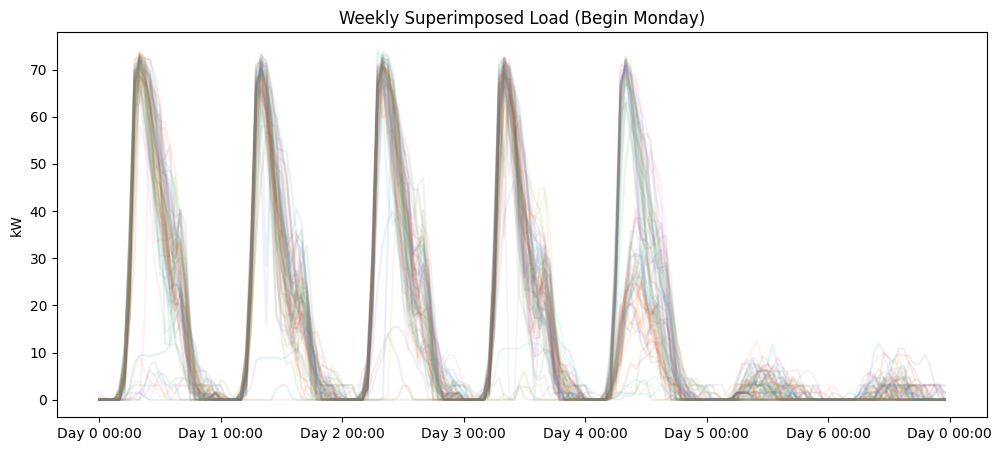

In [14]:
plot_superimpose(data.Load,days=7,title='Weekly Superimposed Load (Begin Monday)')

Let's remove Friday, Saturday, and Sunday, for now

They are clearly a different behavioral pattern, "non-stationary"

In [15]:
data = data[data.index.weekday<4]
data.plot(title='Weekday Load')

Now just one day to superimpose

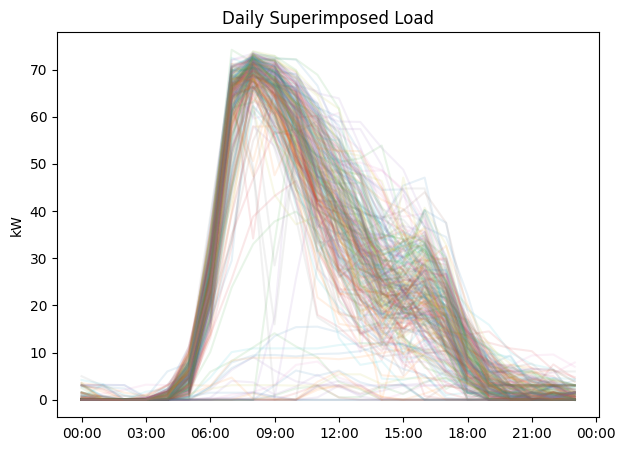

In [16]:
plot_superimpose(data.Load,title='Daily Superimposed Load')

## Daily reshape

Make a "stack" of each day's data

In [17]:
x = data.Load
xDaily = x.values[:24*(len(x)//24)].reshape(-1,24)
xDaily = pd.DataFrame(xDaily)
xDaily

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,1.4,16.9,50.7,67.4,60.0,...,23.5,24.5,22.9,10.2,5.3,0.9,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.5,26.2,45.1,65.5,60.4,...,11.2,13.8,17.6,14.1,5.2,1.8,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.5,2.5,16.7,44.6,66.4,61.2,...,21.4,19.4,14.5,10.5,6.4,1.4,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.3,16.8,45.8,66.2,60.8,...,8.5,19.7,15.8,6.3,1.3,1.6,1.8,3.0,2.8,0.0
4,0.0,0.0,0.0,0.0,0.0,2.8,29.0,67.1,71.8,65.9,...,27.4,19.8,14.6,11.9,2.2,3.0,1.8,0.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.0,0.0,0.0,0.0,1.0,6.3,30.2,59.9,67.4,61.4,...,18.1,22.1,27.4,26.0,13.4,3.6,0.0,0.0,1.6,0.7
284,0.0,0.0,0.0,0.0,2.2,7.0,24.6,64.4,71.6,65.1,...,27.7,31.9,28.4,26.7,14.5,10.3,3.2,4.6,3.4,2.1
285,0.0,0.0,0.0,0.0,1.9,7.7,25.6,66.6,68.9,64.8,...,11.8,20.0,28.7,17.6,3.6,2.6,3.2,0.0,1.4,1.1
286,0.0,0.0,0.0,0.0,2.2,6.5,24.2,58.8,68.9,61.7,...,32.6,30.4,25.9,24.4,14.4,5.5,6.1,6.6,5.6,7.9


## Calculate z-score

Then, for each column, calculate the mean and standard devation

In [18]:
mean = xDaily.mean()
std = xDaily.std()

And then alculate z-score

In [19]:
z = (xDaily - mean)/std
data['zscore'] = z.values.flatten()

show_zscore(data['2019-2-20 6:00':'2019-2-20 18:00'])

,Load,zscore
Datetime,,
2019-02-20 06:00:00,26.400000,0.331124
2019-02-20 07:00:00,66.000000,0.480311
2019-02-20 08:00:00,70.200000,0.357216
2019-02-20 09:00:00,69.500000,0.521493
2019-02-20 10:00:00,64.800000,0.682531
2019-02-20 11:00:00,58.600000,0.955663
2019-02-20 12:00:00,42.300000,0.388009
2019-02-20 13:00:00,34.100000,0.323143
2019-02-20 14:00:00,35.100000,1.023765


## Remove outliers

Now we can remove the "rare" data with z-score > 2 (95% confidence)

In [20]:
data['LoadClean'] = data.Load
data.loc[data.zscore.abs()>2,'LoadClean'] = nan

Visualize:

In [21]:
data['Outliers'] = nan
data.loc[data.zscore.abs()>2,'Outliers'] = data.Load[data.zscore.abs()>2].values
data['2019-2-17':'2019-2-28'][['Load','Outliers']].plot()#figsize=(12,5))

Much cleaner!

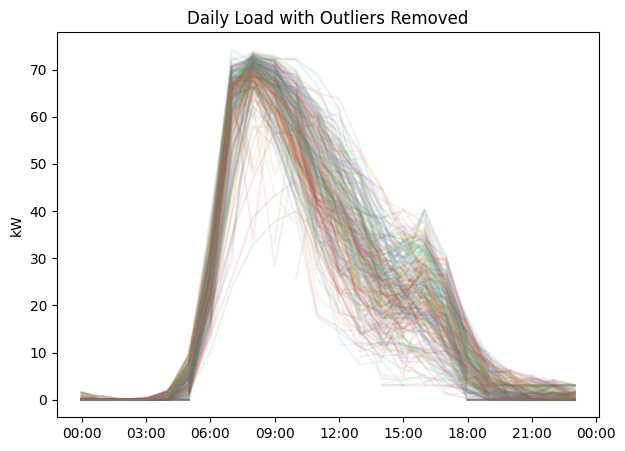

In [32]:
plot_superimpose(data.LoadClean,title='Daily Load with Outliers Removed')

Note:
- z-score works best with normally distributed data
- load data is almost never normally distributed
- using the _median_ instead of _mean_ helps, some

# K-means

K-means (k "ways") clustering looks for `k` centers, and therefore `k` groups, of the data.

True clustering: we don't have labels (unsupervised).

Algorithm for `k=3`:
1. Put 3 points randomly in the data
2. The 3 points divide the data into 3 areas, or "clusters"
3. The geometric center ("centroid") of each Cluster is calculated
4. Back to Step 2 with the centers as the new points
5. Finish when Step 3 calculates new centers that are almost the same



![kmeans2](https://github.com/woodjmichael/Basi-Fondamentali-del-Machine-Learning/blob/main/images/kmeans2.gif?raw=true)

## Histogram reshape

K-means wants groups of data, not a curve like we have

The trusty histogram makes "bins" (groups) of data easily

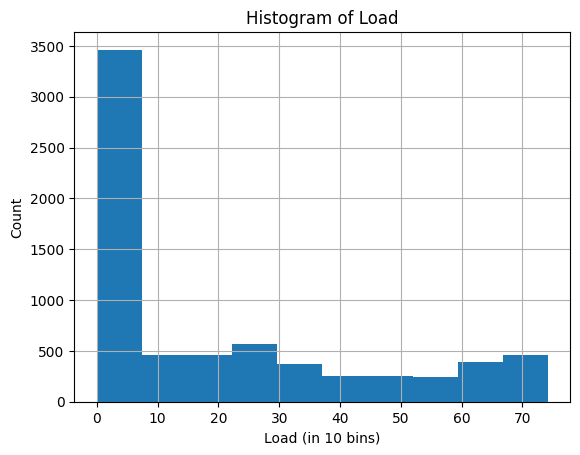

In [23]:
plot_histogram(data.Load)

However, the distribution (shape) is _very_ different at 7:00 and 13:00

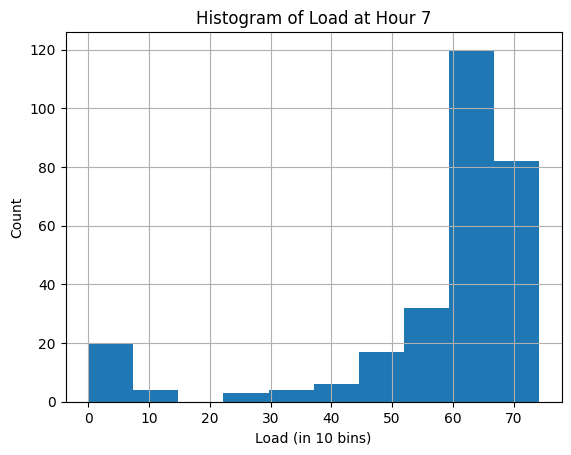

In [24]:
plot_histogram(data.Load,hour=7)

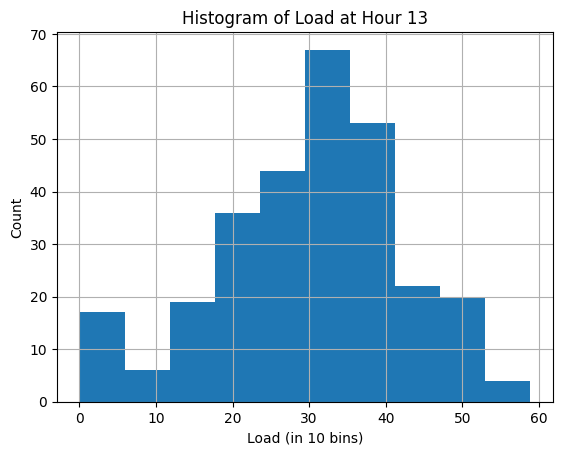

In [25]:
plot_histogram(data.Load,hour=13)

## Calculate k-means

So we should do k-means separately on each hour, like z-score

The threshold/soglia is the line (invisible) between the two left-most clusters

Dots will help see k-means better

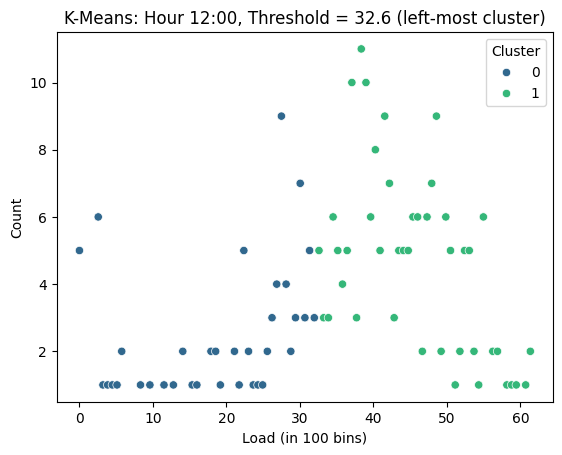

In [26]:
threshold = hourly_distribution_kmeans(data,12,clusters=2)

Practically speaking, only hours 6:00 to 18:00 matter

We want to save the threshold of each hour

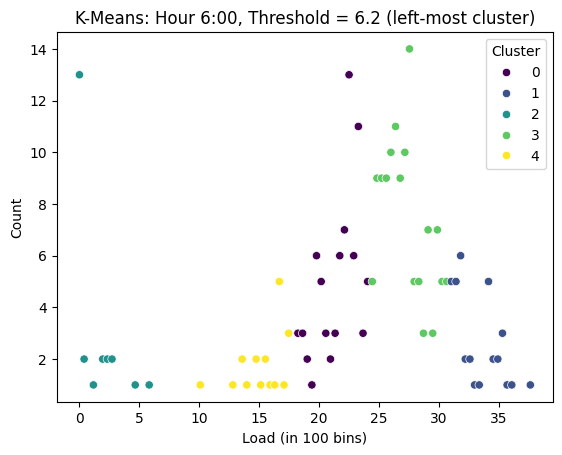

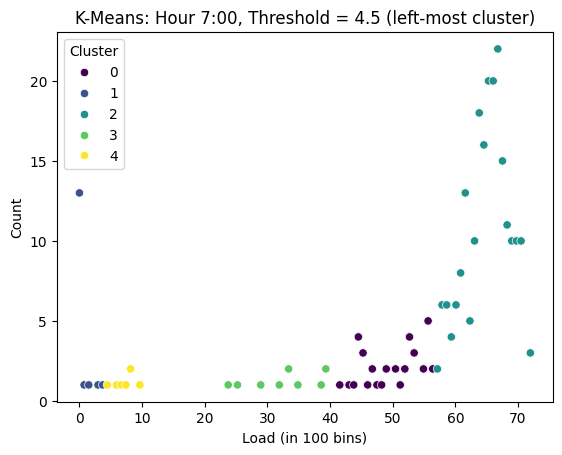

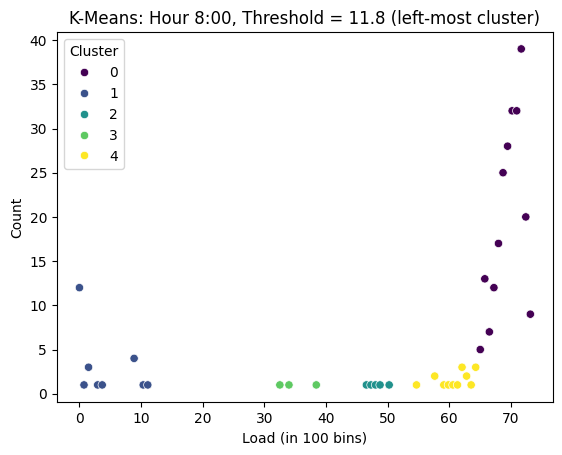

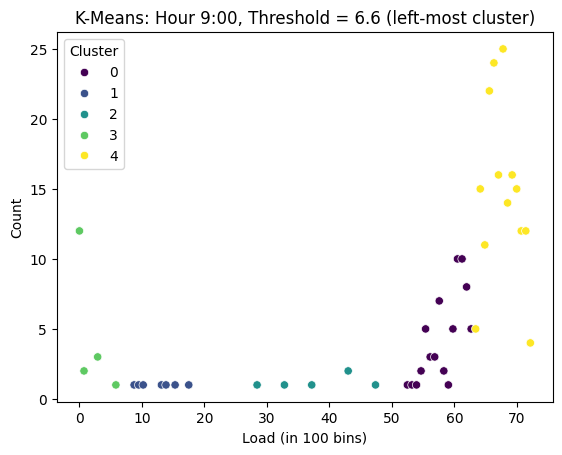

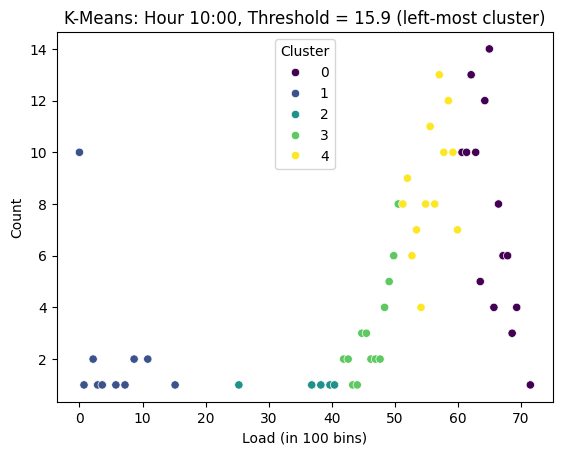

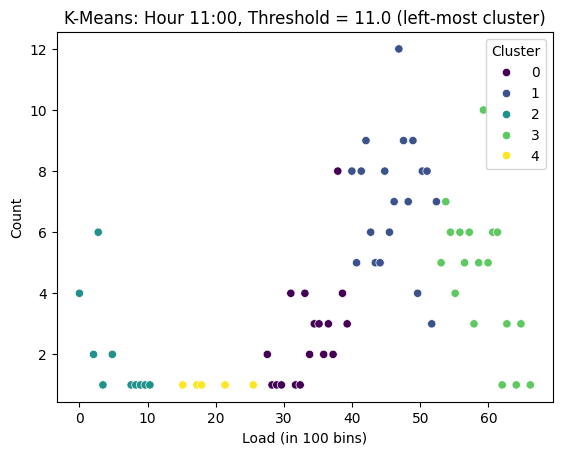

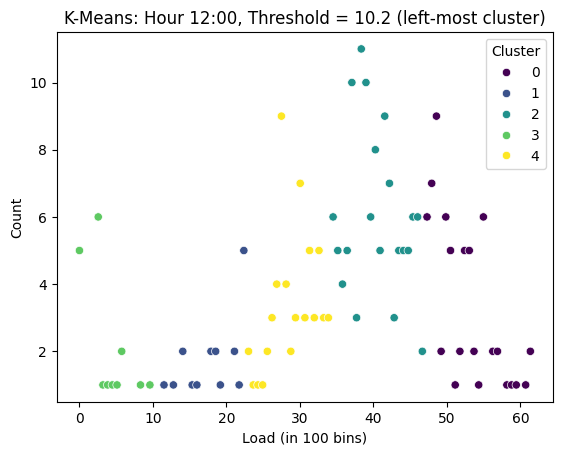

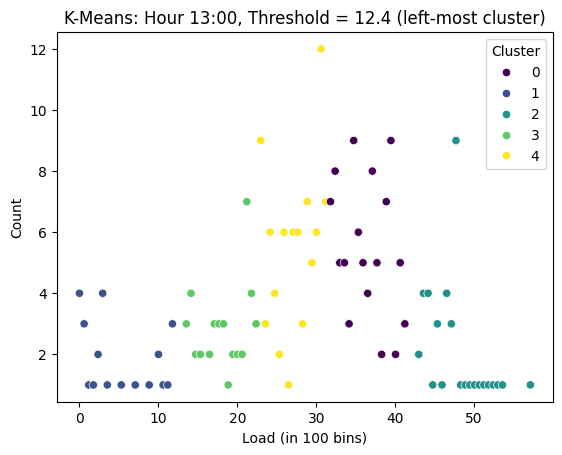

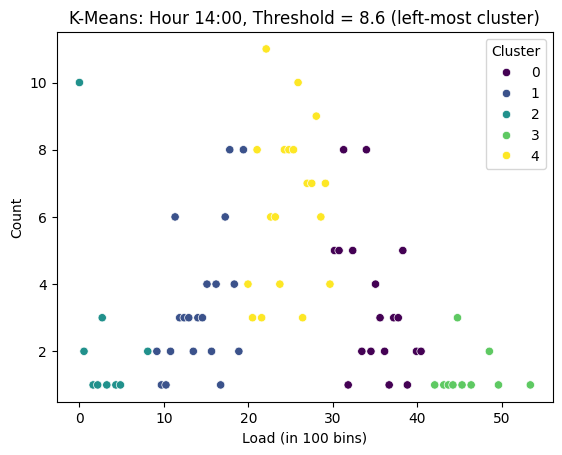

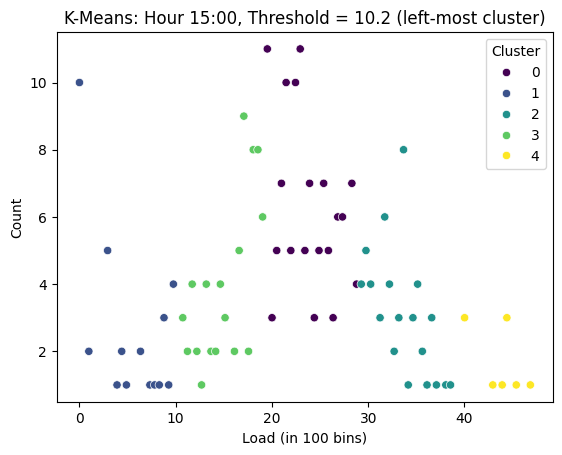

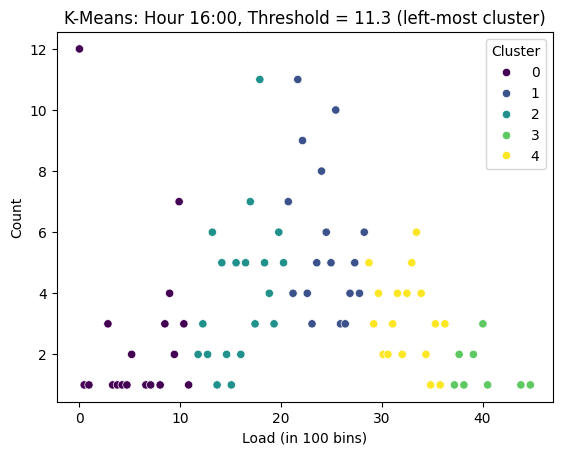

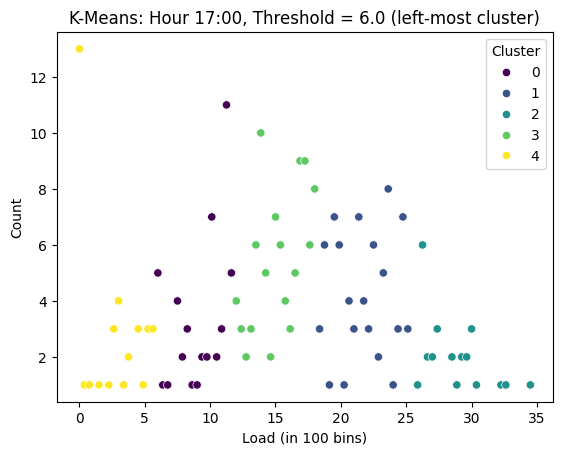

In [34]:
hour = []
thresh = []
for h in range(6,18):
    th = hourly_distribution_kmeans(data,h,clusters=5)
    hour = hour + [h]
    thresh = thresh + [th]

thresholds = pd.DataFrame({'hour':hour,'thresh':thresh})

In [ ]:
thresholds

,hour,thresh
0,6,6.2
1,7,10.4
2,8,4.4
3,9,18.2
4,10,9.4
5,11,11.0
6,12,12.1
7,13,9.4
8,14,10.2
9,15,8.8


## Remove outliers

Now remove any values below the threshold, for each hour

In [29]:
data['LoadCleanKmeans'] = data.Load.values
for h in range(6,18):
    thresh_h = thresholds[thresholds.hour==h].thresh.values[0]
    data.loc[(data.index.hour==h) & (data.LoadCleanKmeans<thresh_h),'LoadCleanKmeans'] = nan
    
data['OutliersKmeans'] = nan
data.loc[data.LoadCleanKmeans.isna(),'OutliersKmeans'] = data.loc[data.LoadCleanKmeans.isna(),'Load'].values

Plot all:

In [30]:
pd.options.plotting.backend='plotly'
data.plot()

Percentage of data that are outliers:

In [31]:
data[['LoadClean','LoadCleanKmeans']].isna().sum() / len(data) * 100

LoadClean          5.714699
LoadCleanKmeans    4.108796
dtype: float64